## Imports

In [1]:
import pandas as pd
import glob
import datasets
import numpy as np

## Load Data

In [2]:
wiki_data = pd.read_csv("../../data/wikidata/wikidata-property-list.csv")
wiki_data = wiki_data[["Title", "ID", "Datatype", "Description"]]
wiki_data

,Title,ID,Datatype,Description
0,head of government,6,item,"head of the executive power of a town, city, m..."
1,brother,7,item,subject has the object as their brother
2,sister,9,item,subject has the object as their sister (female...
3,video,10,Commons file,relevant video
4,highway marker,14,Commons file,graphic representing the highway
...,...,...,...,...
1193,catholic.ru ID,1453,string,identifier on the site catholic.ru
1194,legal form,1454,item,legal form of an organization
1195,list of works,1455,item,link to the article with the works of a person
1196,list of monuments,1456,item,link to the list of heritage monuments in the ...


In [125]:
list(wiki_data[wiki_data["ID"] == 176]["Title"])[0]

'manufacturer'

In [32]:
code_to_lang_dict = {
    "bg": "Bulgarian",
    "ca": "Catalan",
    "cs": "Czech",
    "da": "Danish",
    "de": "German",
    "en": "English",
    "es": "Spanish",
    "fr": "French",
    "hr": "Croatian",
    "hu": "Hungarian",
    "it": "Italian",
    "nl": "Dutch",
    "pl": "Polish",
    "pt": "Portuguese",
    "ro": "Romanian",
    "ru": "Russian",
    "sl": "Slovenian",
    "sr": "Serbian",
    "sv": "Swedish",
    "uk": "Ukrainian",
}

In [33]:
lang_to_code_dict = {v: k for k, v in code_to_lang_dict.items()}

In [128]:
results_dict = {}
results_dict["language"] = []
results_dict["relation"] = []
results_dict["percentage change"] = []
results_dict["new ratio of rows"] = []
results_dict["old ratio of rows"] = []

hf_df = datasets.load_dataset("CalibraGPT/Fact-Completion")
file_names = glob.glob("../../data/result_logs/llama-30b/error-analysis/*.csv")

# confirm grabbing data correctly against LLaMa figure
# uncomment print statement at end of for loop to see
results_dfs = []
count = 0
for file in file_names:
    language = file.split(".csv")[0].split("-")[-1].capitalize()
    error_df = pd.read_csv(file)
    full_hf_df = hf_df[file.split(".csv")[0].split("-")[-1].capitalize()]
    full_hf_df = full_hf_df.to_pandas()
    print(
        f"for {language} we got {error_df.shape[0]} wrong out of {full_hf_df.shape[0]}"
    )
    # print(error_df.head())
    # print(full_hf_df.head())
    # stem is in both
    # dataset id is in both
    # to see if the model got something wrong, see if the dataset id in the full df is in the error
    error_ids = list(error_df["dataset_id"])
    correct = []
    counts = []
    relation_names = []
    for row in full_hf_df.iterrows():
        # track counts
        count += 1
        counts.append(count)
        # track errors
        correct.append(False) if row[1]["dataset_id"] in error_ids else correct.append(
            True
        )
        # track relation titles
        relation_id = int(row[1].relation[1:])
        relation_title = list(wiki_data[wiki_data["ID"] == relation_id]["Title"])[0]
        relation_names.append(relation_title)

    # append result to full df
    full_hf_df["correct"] = correct
    # append language to full df
    full_hf_df["language"] = [language] * full_hf_df.shape[0]
    # append language code to full df
    lang_code = lang_to_code_dict[language]
    full_hf_df["lang_code"] = [lang_code] * full_hf_df.shape[0]
    # append relation title to full df
    full_hf_df["relation_title"] = relation_names
    # also append an arbitrary id to have unique val for each row
    full_hf_df["analysis_id"] = counts

    results_dfs.append(full_hf_df)

results_df = pd.concat(results_dfs)
assert results_df.shape[0] == count

Found cached dataset parquet (/Users/tim/.cache/huggingface/datasets/CalibraGPT___parquet/CalibraGPT--Fact-Completion-24a24a1e4bf6e4a8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/20 [00:00<?, ?it/s]

for Serbian we got 2170 wrong out of 5426
for Ukrainian we got 2138 wrong out of 7918
for Dutch we got 3309 wrong out of 22590
for Swedish we got 3440 wrong out of 21576
for Hungarian we got 1128 wrong out of 4650
for Catalan we got 3021 wrong out of 18898
for Polish we got 2137 wrong out of 9484
for Russian we got 996 wrong out of 3289
for Bulgarian we got 5658 wrong out of 20577
for Slovenian we got 1890 wrong out of 7873
for English we got 2782 wrong out of 26254
for German we got 2323 wrong out of 16287
for Portuguese we got 3719 wrong out of 22974
for Czech we got 2080 wrong out of 9427
for Spanish we got 3430 wrong out of 18786
for Croatian we got 1715 wrong out of 7358
for Danish we got 4255 wrong out of 23365
for French we got 2910 wrong out of 18395
for Italian we got 3192 wrong out of 20448
for Romanian we got 3035 wrong out of 17568


## Explore Data

In [129]:
results_df.head()

,dataset_id,stem,true,false,relation,subject,object,correct,language,lang_code,relation_title,analysis_id
0,calinet_8922,Приус производи,Тоиота,Хонда,P176,Приус,Тоиота,True,Serbian,sr,manufacturer,1
1,rome_5025,Сундар Пицхаи ради за,Гоогле,Аппле,P108,Сундар Пицхаи,Гоогле,False,Serbian,sr,employer,2
2,rome_21333,"Главни град Народне Републике Кине,",Пекинг,Кабул,P36,Народна Република Кина,Пекинг,True,Serbian,sr,capital,3
3,rome_8738,У Синт Мартену разумеју,холандски,дански,P37,Синт Маартен,холандски,True,Serbian,sr,official language,4
4,rome_8783,Хаас Хоусе се налази у месту,Беч,Алберта,P131,Хаас Хоусе,Беч,True,Serbian,sr,is in the administrative territorial entity,5


In [130]:
# average number of times a dataset_id gets shared across langs?
# 11.5
np.mean(results_df["dataset_id"].value_counts())

11.546545288337015

<Axes: >

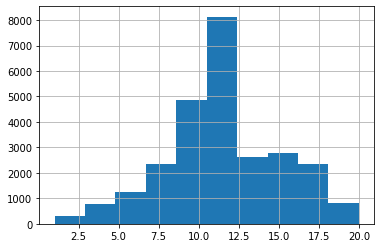

In [131]:
# hist of our usage
results_df["dataset_id"].value_counts().hist()

In [132]:
# how many dataset_id's get used across all 20 langs?
np.count_nonzero(results_df["dataset_id"].value_counts().values == 20)

214

In [133]:
# how many dataset_id's get used across only 1 lang?
np.count_nonzero(results_df["dataset_id"].value_counts().values == 1)

77

In [134]:
results_df[results_df["language"] == "English"]["correct"].value_counts()

True     23472
False     2782
Name: correct, dtype: int64

In [143]:
# look at all the versions of our prius fact, which appears in 16 cuts.
results_df[results_df["dataset_id"] == "calinet_8922"]

,dataset_id,stem,true,false,relation,subject,object,correct,language,lang_code,relation_title,analysis_id
0,calinet_8922,Приус производи,Тоиота,Хонда,P176,Приус,Тоиота,True,Serbian,sr,manufacturer,1
1,calinet_8922,Prius виробляє,Toyota,Honda,P176,Prius,Toyota,True,Ukrainian,uk,manufacturer,5428
2,calinet_8922,Prius wordt geproduceerd door,Toyota,Honda,P176,Prius,Toyota,True,Dutch,nl,manufacturer,13347
3,calinet_8922,Prius tillverkas av,Toyota,Honda,P176,Prius,Toyota,True,Swedish,sv,manufacturer,35938
3,calinet_8922,Prius és produït per <br> El Prius és produït per,Toyota,Honda,P176,Prius,Toyota,True,Catalan,ca,manufacturer,62164
2,calinet_8922,Prius се произвежда от,Toyota,Honda,P176,Prius,Toyota,True,Bulgarian,bg,manufacturer,93834
0,calinet_8922,Prius proizvaja,Toyota,Honda,P176,Prius,Toyota,True,Slovenian,sl,manufacturer,114409
4,calinet_8922,Prius is produced by,Toyota,Honda,P176,Prius,Toyota,True,English,en,manufacturer,122286
2,calinet_8922,Prius é produzido pela,Toyota,honda,P176,Prius,Toyota,True,Portuguese,pt,manufacturer,164825
0,calinet_8922,Prius vyrábí,Toyota,Honda,P176,Prius,Toyota,True,Czech,cs,manufacturer,187797


In [136]:
# what is the most missed entity?
# out of our 55328 total errors..
results_df[results_df["correct"] == False].shape[0]

55328

In [195]:
# most frequent entities + relation title pairs
results_df[["subject", "relation_title"]].value_counts()[:20]

subject              relation_title       
Mac OS               developer                73
They                 record label             71
Vincent van Gogh     work location            66
iOS                  developer                51
Tizen                developer                50
Arcapita             located in               49
SNES-CD              manufacturer             49
Sichuan              shares border with       47
Tree Hill            original network         46
Daniel               language                 45
Berry Gordy          record label             45
PAX                  located in               42
Couto Misto          official language        41
Sri Lanka            official language        40
Max Weber            field of work            39
Heilmann & Littmann  headquarters location    39
Feynman              field of work            39
Tycho Brahe          work location            39
Prison Break         original network         38
Illinois             share

In [154]:
entities = {}
for row in results_df.iterrows():
    subject = row[1].subject
    val = row[1].correct
    if row[1].subject not in entities:
        entities[subject] = {"correct": 0, "incorrect": 0}

    if val:
        entities[subject]["correct"] += 1
    else:
        entities[subject]["incorrect"] += 1

In [197]:
entity_names = []
correct = []
incorrect = []
total = []
pct = []
for k, v in entities.items():
    entity_names.append(k)
    correct.append(v["correct"])
    incorrect.append(v["incorrect"])
    total.append(int(v["correct"]) + int(v["incorrect"]))
    pct.append(int(v["correct"]) / (int(v["correct"]) + int(v["incorrect"])))

In [198]:
entity_analysis_df = pd.DataFrame(
    {
        "entity": entity_names,
        "num_correct": correct,
        "num_incorrect": incorrect,
        "total_usages": total,
        "percent_accuracy": pct,
    }
)

## Most Correct and Incorrect by Raw Count

In [199]:
# the top 20 most incorrect (by raw count)
entity_analysis_df.sort_values(by="num_incorrect", ascending=False)[:20]

,entity,num_correct,num_incorrect,total_usages,percent_accuracy
6779,They,31,70,101,0.306931
7229,Tree Hill,6,40,46,0.130435
14445,Doctor Who,45,38,83,0.542169
38236,Oni,24,35,59,0.406780
30250,De,17,34,51,0.333333
5249,Cam-Pact,3,33,36,0.083333
5904,Sushi Pack,1,31,32,0.031250
6160,VAX,4,30,34,0.117647
9527,ASCI Red,1,29,30,0.033333
7118,Life Unexpected,3,28,31,0.096774


In [200]:
# the top 20 most correct (by raw count)
entity_analysis_df.sort_values(by="num_correct", ascending=False)[:20]

,entity,num_correct,num_incorrect,total_usages,percent_accuracy
6552,Mac OS,92,0,92,1.000000
12379,Iran,69,1,70,0.985714
15287,Peru,68,4,72,0.944444
9387,Windows 7,66,0,66,1.000000
6174,iPod,65,0,65,1.000000
13503,Kerala,65,3,68,0.955882
12885,Vincent van Gogh,64,2,66,0.969697
14846,Malawi,62,0,62,1.000000
12655,Uttar Pradesh,60,4,64,0.937500
18828,Tycho Brahe,59,1,60,0.983333


## Most Correct and Incorrect by Percent (at least 10 usages)

In [212]:
# there are 6258 entities that were used more than 10 times and always correct!

len(
    entity_analysis_df[
        (entity_analysis_df["total_usages"] >= 10)
        & (entity_analysis_df["percent_accuracy"] == 1.0)
    ]
)

6258

In [213]:
# and they comprise 82k of our corrects.
sum(
    entity_analysis_df[
        (entity_analysis_df["total_usages"] >= 10)
        & (entity_analysis_df["percent_accuracy"] == 1.0)
    ]["total_usages"]
)

82047

In [215]:
# meanwhile, there were just 293 entities that were consistently bad
len(
    entity_analysis_df[
        (entity_analysis_df["total_usages"] >= 10)
        & (entity_analysis_df["percent_accuracy"] == 0.0)
    ]
)

293

In [216]:
# and they comprise just 4057 of our incorrect
sum(
    entity_analysis_df[
        (entity_analysis_df["total_usages"] >= 10)
        & (entity_analysis_df["percent_accuracy"] == 0.0)
    ]["total_usages"]
)

4057

In [217]:
# meanwhile, there were just 293 entities that were consistently bad
entity_analysis_df[
    (entity_analysis_df["total_usages"] >= 10)
    & (entity_analysis_df["percent_accuracy"] == 0.0)
]

,entity,num_correct,num_incorrect,total_usages,percent_accuracy
772,Nao Takasugi,0,13,13,0.0
2033,Sun Yingjie,0,20,20,0.0
3629,Ju Yingzhi,0,20,20,0.0
5277,John McEntee,0,17,17,0.0
5287,Pedrabranca,0,12,12,0.0
...,...,...,...,...,...
32555,Big Impression,0,12,12,0.0
33205,Honey War,0,10,10,0.0
33590,Joan Waste,0,10,10,0.0
34046,Erin Smith,0,13,13,0.0
